# 7. Probability transformation function

In [47]:
import pathlib
from tqdm import tqdm

import numpy as np
import scipy as sp
from scipy.special import erf
import pandas as pd

from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt

import config
import utils
from domain import Domain

In [2]:
cache_path = pathlib.Path(config.cache_path)
cache_path.mkdir(exist_ok=True)

fig_path = pathlib.Path(config.fig_path)
fig_path.mkdir(exist_ok=True)

## Load everything

### Load domain

In [3]:
dom = Domain().load(cache_path / 'domain_hpx5_wholesky.npz')
hpx_nside = dom.nside
hpx_ipix  = dom.ipix
D_edgs = dom.D_
D  = dom.D
dD = dom.dD

hpx_order = int(np.log2(hpx_nside))
hpx_npix = 12 * 4**hpx_order

### Load AG map

In [4]:
res = np.load(cache_path / 'am_map.npz')
AG_map0 = res['ag_map']
print("shape(AG_map0) =", AG_map0.shape)

# Downscale the map if necessary
AG_map = np.zeros(hpx_npix)
if hpx_order < 7:
    for i0 in range(AG_map0.shape[0]):
        i = i0 // 4**(7-hpx_order)
        AG_map[i] += AG_map0[i0] / 4**(7-hpx_order)
print("shape(AG_map) =", AG_map.shape)

shape(AG_map0) = (196608,)
shape(AG_map) = (12288,)


### Load the model for parallax error

In [ ]:
f = cache_path / 'logplxerr_nvis_g.npz'
res = np.load(f, allow_pickle=True)
nvis_bins = res['nvis_bins']
plxerr_nvis_g = pd.DataFrame(dict(res['plxerr_nvis_g'].tolist())).T

### Load statistics on the parallax errors

In [34]:
pe0 = pd.read_hdf(cache_path / 'dr3_plxerr_stats.hdf5', key='df')
pe0

,hpx,g_bin,parallax_error,visibility_periods_used
0,115097,90.431837,NaN,5.0
1,51930,93.920902,1.402338,11.0
2,51971,96.581129,NaN,7.0
3,62925,95.783810,2.076251,10.0
4,129137,72.139887,0.037037,23.0
...,...,...,...,...
9983129,193153,94.197821,0.916554,15.0
9983130,9024,96.154636,NaN,12.0
9983131,114811,91.732077,NaN,7.0
9983132,12966,92.579426,0.658761,15.0


In [35]:
print("NaNs:")
print(pe0.isna().sum())

pe = pe0[pe0['g_bin']>=0].copy()
pe.dropna(inplace=True)

peh = pe.groupby('hpx').agg(nvis=('visibility_periods_used', 'median')).reset_index()
peh['nvis_bin'] = pd.cut(peh['nvis'], bins=nvis_bins).astype(str)

del(pe0)
del(pe)

NaNs:
hpx                              0
g_bin                        14518
parallax_error             1886571
visibility_periods_used          0
dtype: int64


In [36]:
peh

,hpx,nvis,nvis_bin
0,0,12.0,"(2.0, 14.0]"
1,1,14.5,"(14.0, 15.0]"
2,2,16.0,"(15.0, 16.0]"
3,3,16.0,"(15.0, 16.0]"
4,5,15.0,"(14.0, 15.0]"
...,...,...,...
193935,196603,16.0,"(15.0, 16.0]"
193936,196604,15.5,"(15.0, 16.0]"
193937,196605,14.0,"(2.0, 14.0]"
193938,196606,16.0,"(15.0, 16.0]"


### Load the XP selection function

In [37]:
fpath = cache_path / f"sf_xp_hpx{hpx_order}_g.npz"
res = np.load(fpath)
G_edgs = res['G_']
#prb_xp = res['prb_xp']
prb_xp = res['prb_xp_smo']
print("shape(prb_xp) =", prb_xp.shape)

del(res)

shape(prb_xp) = (12288, 109)


### Load and prepare the luminosity function

In [38]:
res = np.load('NGC_6397_lf.npz')
M_hist = res['rgb_mg_hist']
M_bins = res['rgb_mg_edges']

In [39]:
# Interpolate the LF
M_ = 0.5*(M_bins[:-1] + M_bins[1:])
fn_m_interp = sp.interpolate.interp1d(M_, M_hist, bounds_error=False, fill_value=(0.0, 0.0))
M = np.linspace(M_[0], M_[-1], 161)
Phi = fn_m_interp(M)

In [40]:
# Normalize the LF as a PDF
C = np.trapz(Phi, M)
Phi /= C
print("Normalization:", C)

Normalization: 170.0


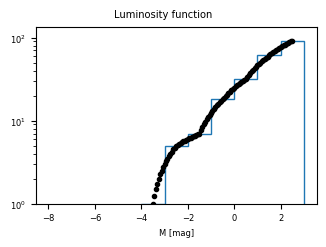

In [41]:
plt.rc('font', size=6.0)
inch = 2.54  ## cm
width, height = 8/inch, 6/inch
plt.figure(figsize=(width, height), layout='constrained')
plt.suptitle("Luminosity function")

plt.stairs(M_hist, M_bins)
plt.plot(M, fn_m_interp(M), '.k')
plt.xlabel("M [mag]")
plt.yscale('log')
plt.ylim(ymin=1)

plt.savefig(fig_path / 'lf.pdf')
plt.show()
plt.close()

## Evaluate the transformation function

In [48]:
G__ = 0.5*(G_edgs[:-1] + G_edgs[1:])

# Dims: hpx, D, D'
K = np.nan * np.zeros((len(hpx_ipix), len(D), len(D)))
TF = K.copy()

DD = D[None,:,None]
DD_ = D[:,None,None]

G_lim = 16.0
q = 4.0
for k, hpx in tqdm(enumerate(hpx_ipix), total=len(hpx_ipix)):
    # Dims: D, D', M
    GG = M[None,None,:] + AG_map[hpx] + 5.0*np.log10(DD) + 10.0

    sigma_plx = np.inf * np.ones_like(GG)
    nvis_bin = peh.iloc[hpx]['nvis_bin']
    sigma_plx = 10**np.interp(GG, plxerr_nvis_g.loc[nvis_bin]['G'], plxerr_nvis_g.loc[nvis_bin]['logsigma_plx'])

    # Magnitude selection
    SF_mag = GG <= G_lim
    # Parallax selection
    SF_plx = 1/DD_ > q*sigma_plx
    # XP selection
    SF_xp_interp = sp.interpolate.interp1d(G__, prb_xp[hpx], bounds_error=False, fill_value=(0.0, 0.0))
    SF_xp = SF_xp_interp(GG)

    dTF = 0.5*erf((1/D_edgs[:-1,None,None] - 1.0/D[None,:,None]) / (np.sqrt(2)*sigma_plx)) \
        - 0.5*erf((1/D_edgs[1:,None,None] - 1.0/D[None,:,None]) / (np.sqrt(2)*sigma_plx))
    K[hpx] = np.trapz(Phi[None,None,:] * (SF_mag & SF_plx).astype(float) * SF_xp * dTF, M, axis=-1)
    TF[hpx] = K[hpx] * dom.dVol[None,:]

    isnan = np.any(np.isnan(TF[hpx]))
    if isnan:
        print(f"hpx={hpx}: NaN")


100%|██████████████████████████████████████████████████████████████████████████████████| 12288/12288 [01:32<00:00, 133.13it/s]


## Make some plots

ipix_: [7181 7596]


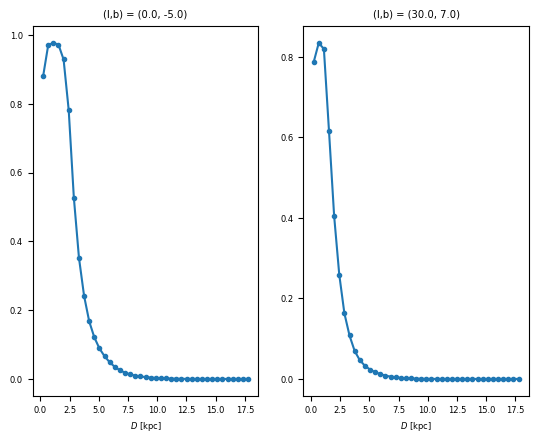

In [50]:
l = [ 0, 30]
b = [-5,  7]
co = SkyCoord(l, b, frame='galactic', unit='deg')
hp = HEALPix(nside=hpx_nside, order='nested', frame='icrs')
ipix_ = hp.skycoord_to_healpix(co)
print("ipix_:", ipix_)

plt.figure()

for i, hpx in enumerate(ipix_):
    plt.subplot(1, 2, i+1)
    plt.title(f"(l,b) = ({co[i].l.deg}, {co[i].b.deg})")

    ih = np.argwhere(hpx_ipix == hpx)[0][0]
    im = plt.plot(D, np.diag(K[ih]), '.-')
    plt.xlabel("$D$ [kpc]")

plt.show()
plt.close()

ipix_: [7181 7596]
D[18] = 8.12744 [kpc]


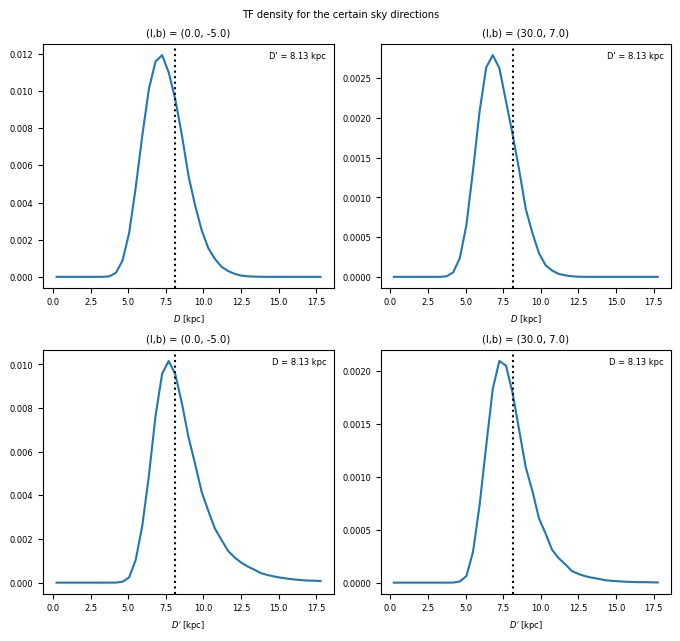

In [53]:
plt.rc('font', size=6.0)
inch = 2.54  ## cm
width, height = 17/inch, 16/inch
plt.figure(figsize=(width, height), layout='constrained')
plt.suptitle("TF density for the certain sky directions")

l = [ 0, 30]
b = [-5,  7]
co = SkyCoord(l, b, frame='galactic', unit='deg')
hp = HEALPix(nside=hpx_nside, order='nested', frame='icrs')
ipix_ = hp.skycoord_to_healpix(co)
print("ipix_:", ipix_)

i = 18
print(f"D[{i}] = {D[i]:g} [kpc]")
for k, hpx in enumerate(ipix_):
    plt.subplot(2, 2, k+1)
    plt.title(f"(l,b) = ({co[k].l.deg}, {co[k].b.deg})")

    ih = np.argwhere(hpx_ipix == hpx)[0][0]

    plt.plot(D, K[ih,:,i], '-', label=f"D' = {D[i]:.3g} kpc")
    plt.axvline(D[i], ls=':', c='k')
    plt.xlabel("$D$ [kpc]")

    plt.legend(handlelength=0, loc='upper right', frameon=False)
    #plt.yscale('log')

for k, hpx in enumerate(ipix_):
    plt.subplot(2, 2, 2+k+1)
    plt.title(f"(l,b) = ({co[k].l.deg}, {co[k].b.deg})")

    ih = np.argwhere(hpx_ipix == hpx)[0][0]

    plt.plot(D, K[ih,i,:], '-', label=f"D = {D[i]:.3g} kpc")
    plt.axvline(D[i], ls=':', c='k')
    plt.xlabel("$D'$ [kpc]")

    plt.legend(handlelength=0, loc='upper right', frameon=False)
    #plt.yscale('log')

plt.show()
#plt.savefig(fig_path / 'tf_1.pdf')
plt.close()

ipix_: [7181 7596]


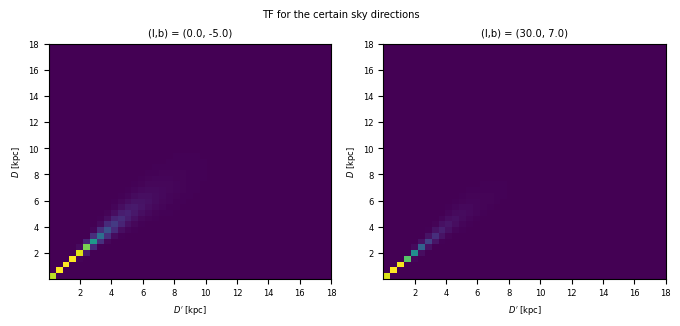

In [55]:
plt.rc('font', size=6.0)
inch = 2.54  ## cm
width, height = 17/inch, 8/inch
plt.figure(figsize=(width, height), layout='constrained')
plt.suptitle("TF for the certain sky directions")

l = [ 0, 30]
b = [-5,  7]
co = SkyCoord(l, b, frame='galactic', unit='deg')
hp = HEALPix(nside=hpx_nside, order='nested', frame='icrs')
ipix_ = hp.skycoord_to_healpix(co)
print("ipix_:", ipix_)

for i, hpx in enumerate(ipix_):
    plt.subplot(1, 2, i+1)
    plt.title(f"(l,b) = ({co[i].l.deg}, {co[i].b.deg})")

    ih = np.argwhere(hpx_ipix == hpx)[0][0]
    #im = plt.pcolormesh(D, D, CF[ih] * (D_[1:,None] - D_[:-1,None]) / (D_[None,1:] - D_[None,:-1]), norm=LogNorm(), rasterized=True)
    im = plt.pcolormesh(D, D, K[ih], rasterized=True)
    #plt.colorbar(im)
    plt.xlabel("$D'$ [kpc]")
    plt.ylabel("$D$ [kpc]")

plt.show()
#plt.savefig('fig/cf_2.pdf')
plt.close()

## Save the TF

In [57]:
print("isnan(TF) =", np.any(np.isnan(TF)))
np.savez_compressed(cache_path / 'tf.npz', M=M, Phi=Phi, TF=TF)

isnan(TF) = False
